## Simulated Washout in-silico DNA vs RIBO1B (reverse strand)
### Position: M13mp18:4984

A total of 6 subsampled BAM files were produced mixing in different percentages of reads mapping on the reverse strand coming from both DNA_only (2023) and RIBO1B runs. For each mixed subsampled BAM file, a fixed amount of about 100k reads were used using increasing percentages of DNA reads to simulate an in-silico "washout" effect (0, 20, 40, 60, 80, 100 % of DNA reads vs RIBO1B reads). The site used for this analysis was the M13mp18:4984, which is the expected incorporation site for the rG in RIBO1B construct. Here complement bases are shown.

In [1]:
# importing basic modules
import pandas as pd
import pysam
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import os
from glob import glob

# to plot better figures
plt.tight_layout()

# ---------- defining Utils Functions --------------- #

def get_results_list(bam_file_path, contig, start_pos_1_based, end_pos_1_based):
    bam_file = pysam.AlignmentFile(bam_file_path)
    start_pos_0_based = start_pos_1_based - 1
    end_pos_0_based = end_pos_1_based
    
    result = []
    for pileupcolumn in bam_file.pileup(contig, start_pos_0_based, end_pos_0_based, truncate=True, min_base_quality=0, max_depth=10000000):
        result.append(pileupcolumn.get_query_sequences(mark_matches=True, add_indels=True))
    bam_file.close()
    
    return result


def get_stats(result_list_single_pos, verbose=True):
    T_count = 0
    C_count = 0
    G_count = 0
    A_count = 0
    del_count = 0
    for i in result_list_single_pos:
        if i.lower() == "t":
            T_count += 1
        elif i.lower() == "c":
            C_count += 1
        elif i.lower() == "g":
            G_count += 1
        elif i.lower() == "a":
            A_count += 1
        if i.lower() == "*":
            del_count += 1
        if "+" in i.lower():
            i_splitted = i.lower().split("+")
            if i_splitted[0] == "t":
                T_count += 1
            elif i_splitted[0] == "c":
                C_count += 1
            elif i_splitted[0] == "g":
                G_count += 1
            elif i_splitted[0]  == "a":
                A_count += 1
        if "-" in i.lower():
            i_splitted = i.lower().split("-")
            if i_splitted[0] == "t":
                T_count += 1
            elif i_splitted[0] == "c":
                C_count += 1
            elif i_splitted[0] == "g":
                G_count += 1
            elif i_splitted[0]  == "a":
                A_count += 1
                
    if verbose:
        print("T", T_count)
        print("C", C_count)
        print("G", G_count)
        print("A", A_count)
        print("Deletions", del_count)
    
    output = [T_count, C_count, G_count, A_count, del_count]
    return output


def get_insertions(bam_file_path, contig, start_pos_1_based, end_pos_1_based):
    bam_file = pysam.AlignmentFile(bam_file_path)
    start_pos_0_based = start_pos_1_based - 2 # -2 cause we want to calculate insertion of the previous reference positions in 0-based index
    end_pos_0_based = end_pos_1_based - 1 # -1 cause we want to calculate insertion of the previous reference positions in 0-based index with right opened intervals (pythonic way)
    
    #start_time = datetime.now()
    result = []
    for pileupcolumn in bam_file.pileup(contig, start_pos_0_based, end_pos_0_based, truncate=True, min_base_quality=0, max_depth=10000000):
        result.append(pileupcolumn.get_query_sequences(mark_matches=True, add_indels=True))
    #stop_time = datetime.now()
    bam_file.close()
    
    final_output_insertions = []
    for pos in result:
        ins_count = 0
        for read in pos:
            if "+" in read.lower():
                ins_count += 1
        final_output_insertions.append(ins_count)
    return final_output_insertions


def calc_freq_bases(df):
    freq = pd.DataFrame(df.iloc[:,0:6].values / np.array(df.iloc[:,0:6].sum(axis=1).values).reshape(df.shape[0],1), 
             columns=["T_freq", "C_freq", "G_freq", "A_freq", "del_freq", "ins_freq"])
    freq["index"] = df.index.to_list()
    freq.set_index("index", inplace=True)
    df_with_freq = pd.concat([df, freq], axis=1)
    return df_with_freq


def get_stats_region(result_list_region, start_pos_1_based=None, stop_pos_1_based=None):
    final_output = []
    for i in result_list_region:
        output = get_stats(i, verbose=False)
        final_output.append(output)
    df_final_output = pd.DataFrame(final_output, columns=["T_count", "C_count", "G_count", "A_count", "del_count"])
    if start_pos_1_based != None and stop_pos_1_based != None:
        index = range(start_pos_1_based, stop_pos_1_based+1)
        df_final_output.index = index
    return df_final_output


def get_stats_from_region(bam_file_path, contig, start_pos_1_based, end_pos_1_based):
    start_time = datetime.now()
    r = get_results_list(bam_file_path, contig, start_pos_1_based, end_pos_1_based)
    df_r = get_stats_region(r, start_pos_1_based, end_pos_1_based)
    insertions = get_insertions(bam_file_path, contig, start_pos_1_based, end_pos_1_based)
    df_r["ins_freq"] = insertions
    df_r_freq = calc_freq_bases(df_r)
    stop_time = datetime.now()
    print(f"[{datetime.now()}] Elapsed time: {stop_time - start_time}", flush=True)
    return df_r_freq

def get_reverse_complment(seq):
    rules = {"A":"T", "T":"A", "G":"C", "C":"G"}
    rev_compl_seq = []
    for b in seq:
        rev_compl_seq.append(rules[b])
    # convert to string
    rev_compl_seq = "".join(rev_compl_seq)
    return rev_compl_seq

<Figure size 432x288 with 0 Axes>

In [2]:
# print mixed datasets produced mixing 100:0; 80:20; 60:40; 40:60; 20:80; 0:100 DNAonly vs RIBO1B reads.
basedir = "/lustre/bio_running/DNA_Ribo_2023/mixed_datasets"
glob(os.path.join(basedir, "mix*bam"))

['/lustre/bio_running/DNA_Ribo_2023/mixed_datasets/mix_dna_ribo_80_20.reverse.bam',
 '/lustre/bio_running/DNA_Ribo_2023/mixed_datasets/mix_dna_ribo_20_80.reverse.bam',
 '/lustre/bio_running/DNA_Ribo_2023/mixed_datasets/mix_dna_ribo_0_100.reverse.bam',
 '/lustre/bio_running/DNA_Ribo_2023/mixed_datasets/mix_dna_ribo_100_0.reverse.bam',
 '/lustre/bio_running/DNA_Ribo_2023/mixed_datasets/mix_dna_ribo_60_40.reverse.bam',
 '/lustre/bio_running/DNA_Ribo_2023/mixed_datasets/mix_dna_ribo_40_60.reverse.bam']

In [3]:
# define ordered bam list
bam_list = ['/lustre/bio_running/DNA_Ribo_2023/mixed_datasets/mix_dna_ribo_0_100.reverse.bam','/lustre/bio_running/DNA_Ribo_2023/mixed_datasets/mix_dna_ribo_20_80.reverse.bam','/lustre/bio_running/DNA_Ribo_2023/mixed_datasets/mix_dna_ribo_40_60.reverse.bam','/lustre/bio_running/DNA_Ribo_2023/mixed_datasets/mix_dna_ribo_60_40.reverse.bam', '/lustre/bio_running/DNA_Ribo_2023/mixed_datasets/mix_dna_ribo_80_20.reverse.bam','/lustre/bio_running/DNA_Ribo_2023/mixed_datasets/mix_dna_ribo_100_0.reverse.bam']
bam_list

['/lustre/bio_running/DNA_Ribo_2023/mixed_datasets/mix_dna_ribo_0_100.reverse.bam',
 '/lustre/bio_running/DNA_Ribo_2023/mixed_datasets/mix_dna_ribo_20_80.reverse.bam',
 '/lustre/bio_running/DNA_Ribo_2023/mixed_datasets/mix_dna_ribo_40_60.reverse.bam',
 '/lustre/bio_running/DNA_Ribo_2023/mixed_datasets/mix_dna_ribo_60_40.reverse.bam',
 '/lustre/bio_running/DNA_Ribo_2023/mixed_datasets/mix_dna_ribo_80_20.reverse.bam',
 '/lustre/bio_running/DNA_Ribo_2023/mixed_datasets/mix_dna_ribo_100_0.reverse.bam']

In [4]:
region="M13mp18"
pos_1_based=4984

stats_list = []
for bam in bam_list:
# get stats
    bam_path = bam
    stats = get_stats_from_region(bam_path, "M13mp18", pos_1_based, pos_1_based)
    # append to stats list
    stats_list.append(stats)
    print(f"\n######################{bam_path}")
    print(stats.iloc[:,6:])
    print("\n\n")

[2023-08-30 17:43:42.727497] Elapsed time: 0:00:15.249923

######################/lustre/bio_running/DNA_Ribo_2023/mixed_datasets/mix_dna_ribo_0_100.reverse.bam
        T_freq    C_freq    G_freq    A_freq  del_freq  ins_freq
4984  0.230073  0.552412  0.001555  0.078406  0.122161  0.015393



[2023-08-30 17:44:01.942185] Elapsed time: 0:00:19.205824

######################/lustre/bio_running/DNA_Ribo_2023/mixed_datasets/mix_dna_ribo_20_80.reverse.bam
        T_freq    C_freq    G_freq    A_freq  del_freq  ins_freq
4984  0.190641  0.631999  0.001514  0.063149  0.099759  0.012937



[2023-08-30 17:44:22.271649] Elapsed time: 0:00:20.322428

######################/lustre/bio_running/DNA_Ribo_2023/mixed_datasets/mix_dna_ribo_40_60.reverse.bam
        T_freq    C_freq   G_freq    A_freq  del_freq  ins_freq
4984  0.152454  0.708708  0.00141  0.049331   0.07825  0.009848



[2023-08-30 17:44:43.494141] Elapsed time: 0:00:21.211533

######################/lustre/bio_running/DNA_Ribo_2023/mixed

In [5]:
# show stats_list
stats_list

[      T_count  C_count  G_count  A_count  del_count  ins_freq    T_freq  \
 4984    10059    24152       68     3428       5341       673  0.230073   
 
         C_freq    G_freq    A_freq  del_freq  ins_freq  
 4984  0.552412  0.001555  0.078406  0.122161  0.015393  ,
       T_count  C_count  G_count  A_count  del_count  ins_freq    T_freq  \
 4984     8311    27552       66     2753       4349       564  0.190641   
 
         C_freq    G_freq    A_freq  del_freq  ins_freq  
 4984  0.631999  0.001514  0.063149  0.099759  0.012937  ,
       T_count  C_count  G_count  A_count  del_count  ins_freq    T_freq  \
 4984     6595    30658       61     2134       3385       426  0.152454   
 
         C_freq   G_freq    A_freq  del_freq  ins_freq  
 4984  0.708708  0.00141  0.049331   0.07825  0.009848  ,
       T_count  C_count  G_count  A_count  del_count  ins_freq    T_freq  \
 4984     4784    33982       54     1510       2403       324  0.111109   
 
         C_freq    G_freq   A_freq 

In [6]:
# convert to complement since here we are analyzing reads mapping on minus strand
rev_compl_columns = ['A_count', 'G_count', 'C_count', 'T_count', 'del_count', 'ins_count', 'A_freq', 'G_freq', 'C_freq', 'T_freq', 'del_freq', 'ins_freq']
for s in stats_list:
    s.columns = rev_compl_columns
# show stats_list
stats_list

[      A_count  G_count  C_count  T_count  del_count  ins_count    A_freq  \
 4984    10059    24152       68     3428       5341        673  0.230073   
 
         G_freq    C_freq    T_freq  del_freq  ins_freq  
 4984  0.552412  0.001555  0.078406  0.122161  0.015393  ,
       A_count  G_count  C_count  T_count  del_count  ins_count    A_freq  \
 4984     8311    27552       66     2753       4349        564  0.190641   
 
         G_freq    C_freq    T_freq  del_freq  ins_freq  
 4984  0.631999  0.001514  0.063149  0.099759  0.012937  ,
       A_count  G_count  C_count  T_count  del_count  ins_count    A_freq  \
 4984     6595    30658       61     2134       3385        426  0.152454   
 
         G_freq   C_freq    T_freq  del_freq  ins_freq  
 4984  0.708708  0.00141  0.049331   0.07825  0.009848  ,
       A_count  G_count  C_count  T_count  del_count  ins_count    A_freq  \
 4984     4784    33982       54     1510       2403        324  0.111109   
 
         G_freq    C_freq  

In [7]:
percs = [100,80,60,40,20,0]
df_list = []
for df,p in zip(stats_list,percs):
    df = df.iloc[:,6:]
    df.index=[p]
    df_list.append(df)
# store labels
labels = df.columns.tolist()
# concat datasets
df = pd.concat(df_list)
df

,A_freq,G_freq,C_freq,T_freq,del_freq,ins_freq
100,0.230073,0.552412,0.001555,0.078406,0.122161,0.015393
80,0.190641,0.631999,0.001514,0.063149,0.099759,0.012937
60,0.152454,0.708708,0.001410,0.049331,0.078250,0.009848
40,0.111109,0.789233,0.001254,0.035070,0.055810,0.007525
20,0.068099,0.872455,0.001283,0.019777,0.033536,0.004851
0,0.025204,0.955624,0.001173,0.005116,0.011264,0.001619


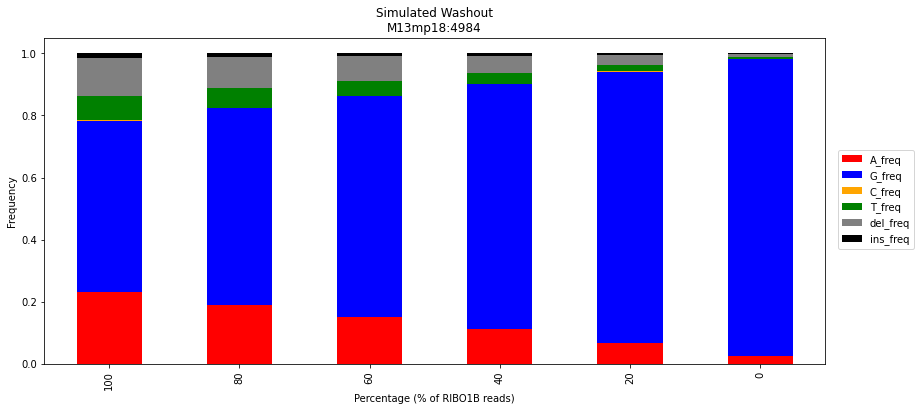

In [8]:
title = f"Simulated Washout\nM13mp18:{pos_1_based}"
df.plot(kind='bar', stacked=True, color=["red", "blue", "orange", "green", "gray", "black"], figsize=(14, 6))
plt.xlabel("Percentage (% of RIBO1B reads)")
plt.ylabel("Frequency")
plt.legend(bbox_to_anchor=(1.12, 0.67))
plt.title(title)

# save image to disk
plt.savefig("/lustre/bio_running/DNA_Ribo_2023/results/simulated_washout/sim_washout_DNA_vs_RIBO1B_site_M13mp18_4984.reverse.tiff", 
            dpi=300, bbox_inches='tight', facecolor='white', transparent=False)

plt.show()

### Produce correlation analysis
The correlatinos will be computed between the total error (mismatched aligned bases + indels) and the RIBO1B reads percentage.

In [9]:
# produce correlation plot aggregating 
# detect expected base
ref_filepath = "/lustre/bio_running/DNA_Ribo/refs/ref.fa"
ref = pysam.FastaFile(ref_filepath)
site = 4984
expected_base = ref.fetch("M13mp18", site-1, site)
# change to complement
expected_base = get_reverse_complment(expected_base)
expected_base

'G'

In [10]:
# compute total error being C the expected refernce base
for s in df_list:
    s["total_error"] = 0
    s["total_error"] = s.drop("G_freq", axis=1).sum(axis=1).values[0]
df_list

/tmp/ipykernel_72104/4169558105.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s["total_error"] = 0
/tmp/ipykernel_72104/4169558105.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s["total_error"] = s.drop("G_freq", axis=1).sum(axis=1).values[0]


[       A_freq    G_freq    C_freq    T_freq  del_freq  ins_freq  total_error
 100  0.230073  0.552412  0.001555  0.078406  0.122161  0.015393     0.447588,
       A_freq    G_freq    C_freq    T_freq  del_freq  ins_freq  total_error
 80  0.190641  0.631999  0.001514  0.063149  0.099759  0.012937     0.368001,
       A_freq    G_freq   C_freq    T_freq  del_freq  ins_freq  total_error
 60  0.152454  0.708708  0.00141  0.049331   0.07825  0.009848     0.291292,
       A_freq    G_freq    C_freq   T_freq  del_freq  ins_freq  total_error
 40  0.111109  0.789233  0.001254  0.03507   0.05581  0.007525     0.210767,
       A_freq    G_freq    C_freq    T_freq  del_freq  ins_freq  total_error
 20  0.068099  0.872455  0.001283  0.019777  0.033536  0.004851     0.127545,
      A_freq    G_freq    C_freq    T_freq  del_freq  ins_freq  total_error
 0  0.025204  0.955624  0.001173  0.005116  0.011264  0.001619     0.044376]

In [11]:
total_errors = []
ribo_perc = []
for s in df_list:
    total_errors.append(s["total_error"].values[0])
    ribo_perc.append(s.index.values[0])
total_errors = pd.DataFrame({"total_error":total_errors, "ribo_perc":ribo_perc})
# save to disk
total_errors.to_csv("/lustre/bio_running/DNA_Ribo_2023/results/simulated_washout/sim_washout_DNA_vs_RIBO1B_site_M13mp18_4984.reverse.total_error.tsv", 
                    sep="\t", index=None)
total_errors

,total_error,ribo_perc
0,0.447588,100
1,0.368001,80
2,0.291292,60
3,0.210767,40
4,0.127545,20
5,0.044376,0


Spearman correlation coefficient with associated p-value: 1.0 0.0
Pearson correlation coefficient with associated p-value: 0.9998810666400115 2.1216875012462178e-08


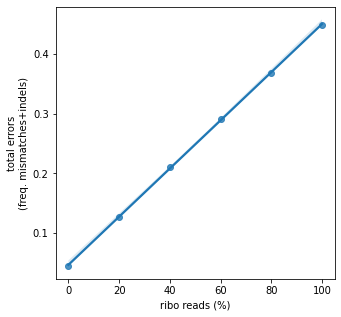

In [12]:
from scipy.stats import spearmanr, pearsonr
plt.figure(figsize=(5,5))
sn.regplot(data=total_errors, x="ribo_perc", y="total_error")
r_spearman, p_spearman = spearmanr(total_errors["total_error"].values, total_errors["ribo_perc"].values)
r_pearson, p_pearson = pearsonr(total_errors["total_error"].values, total_errors["ribo_perc"].values)
print("Spearman correlation coefficient with associated p-value:", r_spearman, p_spearman)
print("Pearson correlation coefficient with associated p-value:", r_pearson, p_pearson)
plt.xlabel("ribo reads (%)")
plt.ylabel("total errors\n(freq. mismatches+indels)")
# save image to disk
plt.savefig("/lustre/bio_running/DNA_Ribo_2023/results/simulated_washout/sim_washout_DNA_vs_RIBO1B_site_M13mp18_4984.reverse.correlation.tiff", 
            dpi=300, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()